In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = torch.device("cpu")
# Load your dataset
df = pd.read_csv("combined_suicide_ideation_dataset.csv")

sampled_df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sampled_df["text"].tolist(), sampled_df["label"].tolist(), test_size=0.2, stratify=sampled_df["label"]
)


In [28]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


In [ ]:
class SuicideDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.labels[idx])}

train_dataset = SuicideDataset(train_encodings, train_labels)
val_dataset = SuicideDataset(val_encodings, val_labels)


In [30]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    no_cuda=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\colin\anaconda3\envs\torch121\lib\site-packages\transformers\training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [31]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,No log,0.361097
2,No log,0.246339
3,No log,0.267002
4,No log,0.271896


TrainOutput(global_step=200, training_loss=0.23487857818603516, metrics={'train_runtime': 2704.0518, 'train_samples_per_second': 1.183, 'train_steps_per_second': 0.074, 'total_flos': 841955377152000.0, 'train_loss': 0.23487857818603516, 'epoch': 4.0})

In [32]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.24633891880512238, 'eval_runtime': 40.7933, 'eval_samples_per_second': 4.903, 'eval_steps_per_second': 0.319, 'epoch': 4.0}


In [33]:
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc

# Run model prediction on validation data
preds_output = trainer.predict(val_dataset)

# Raw logits → predicted class
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids
y_scores = preds_output.predictions[:, 1]  # For ROC: probability of class 1


In [34]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=["non-suicidal", "suicidal"])
print(report)


              precision    recall  f1-score   support

non-suicidal       0.91      0.93      0.92        96
    suicidal       0.93      0.91      0.92       104

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



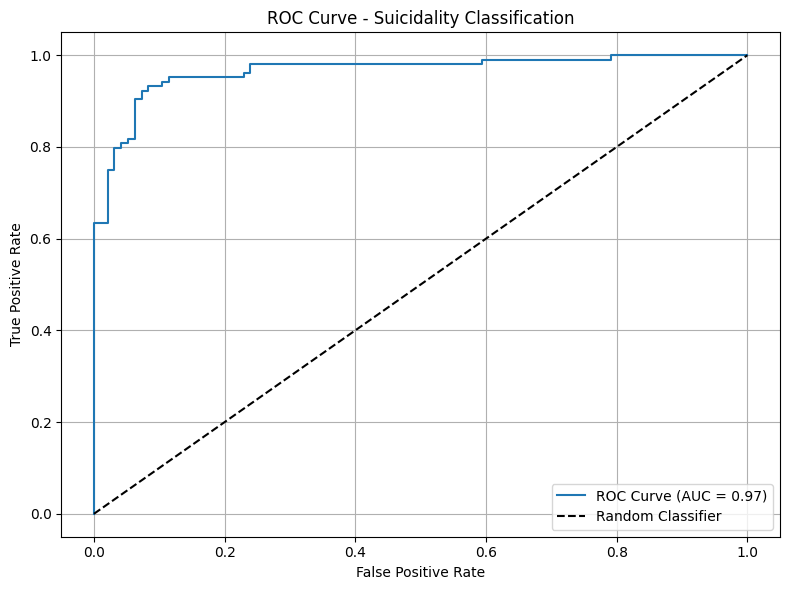

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Suicidality Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
